## Stardist training example

In [1]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
import tensorflow as tf
from pathlib import Path
import json
from tnia.os.os_helper import convert_path_for_wsl

2025-01-22 09:34:49.573018: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 09:34:49.586523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737556489.602585    3110 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737556489.606961    3110 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 09:34:49.622919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Check what devices we have access to....

Not as important to have a beefy GPU for 2D as it is for 3D, but let's check

In [2]:
visible_devices = tf.config.list_physical_devices()
print(visible_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os

# Specify the path to the directory
directory = r'd:/images'

directory = convert_path_for_wsl(directory)

# Check if the directory exists
if os.path.exists(directory):
    print(f"Directory found: {directory}")
else:
    print(f"Directory not found: {directory}")

Directory found: /mnt/d/images


## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is simply because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [4]:

#tnia_images_path = Path(r'/home/bnorthan/images')
tnia_images_path = Path("D:/images")
tnia_images_path = Path("/mnt/d/images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2024_08_29_super_sparse')
#test_name='bsp1-2.jpg'
n_rays = 32

train_path = parent_path / 'patches'

with open(train_path / 'info.json', 'r') as json_file:
    data = json.load(json_file)
    # Access the sub_sample parameter
    sub_sample = data['sub_sample']
    print('sub_sample',sub_sample)
    axes = data['axes']
    print('axes',axes)

image_patch_path = train_path / 'ground truth0'
label_patch_path = train_path / 'input0'

model_path = parent_path / 'model'

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

sub_sample 1
axes YXC


## Use a helper to collect the training data

The helper will also optionally normalize the inputs.

Normalization is a tricky issue sometimes it makes sense to normalize before creating patches, such that the data is normalized based on statistics of a larger region, closer to the normalization range that will be used for prediction. 

In [5]:
from tnia.deeplearning.dl_helper import collect_training_data
add_trivial_channel = False

X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel = add_trivial_channel)

print('type X ', type(X))
print('type Y ', type(Y))
print(Y[0].dtype, Y[0].min(), Y[0].max())
test = Y[0].astype('int16')
print(test.dtype, test.min(), test.max())


100%|██████████| 1571/1571 [01:24<00:00, 18.70it/s]

type X  <class 'list'>
type Y  <class 'list'>
uint16 12 65535
int16 -1 61


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

(256, 256, 3) (256, 256)
0.06851996 0.87496305
2 65535


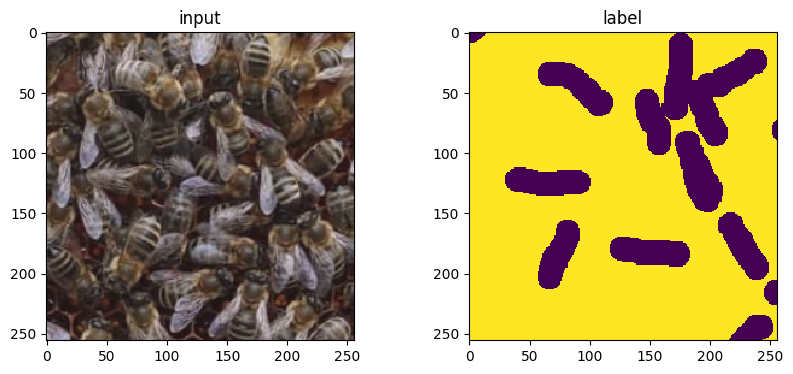

In [6]:
n=8
print(X[n].shape, Y[n].shape)
print(X[n].min(), X[n].max())
print(Y[n].min(), Y[n].max())
fig=imshow_multi2d([X[n], Y[n]], ['input', 'label'], 1,2)

In [7]:
from tnia.deeplearning.dl_helper import divide_training_data

X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, val_size=2)

print('type X_train ', type(X_train))
print(Y[0].dtype, Y[0].min(), Y[0].max())
print(Y_train.dtype, Y_train.min(), Y_train.max())

Y_train = Y_train.astype('int16')
Y_val = Y_val.astype('int16')

type X_train  <class 'numpy.ndarray'>
uint16 12 65535
uint16 0 65535


## Create stardist model

In this cell we create the model.  Make sure to rename the model and give it a descriptive name that conveys the training data and setting used. 

In [8]:
from stardist.models import StarDist2D, Config2D
from tnia.deeplearning.dl_helper import augmenter

n_rays = 32
model_path = "./"
if axes == 'YXC':
    print('axis is YXC')
    n_channel_in =3
else:
    n_channel_in = 1

model_name = "model9"
new_model = True 

if new_model:

    config = Config2D (n_rays=n_rays, axes=axes,n_channel_in=n_channel_in, train_patch_size = (256,256), unet_n_depth=3)
    model = StarDist2D(config=config, name=model_name, basedir=model_path)
else:
    model = StarDist2D(config=None, name=model_name, basedir=model_path)

axis is YXC


I0000 00:00:1737556625.908705    3110 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21769 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [9]:
Y_train.dtype, Y_train.min(), Y_train.max()
Y_val.dtype, Y_val.min(), Y_val.max()

(dtype('int16'), -1, 61)

## Train the model

In [10]:
Y_train.min(), Y_train.max(), Y_train.dtype, Y_train.shape
X_train.min(), X_train.max(), X_train.dtype, X_train.shape

(-0.021978023, 1.1318681, dtype('float32'), (1569, 256, 256, 3))

In [11]:
Y_train.dtype, Y_train.min(), Y_train.max()

(dtype('int16'), -1, 61)

In [14]:
#model.train(X_train, Y_train, validation_data=(X_val,Y_val),epochs=100, steps_per_epoch=200, augmenter=augmenter) 
model.train(X_train, Y_train, validation_data=(X_val,Y_val),epochs=20, steps_per_epoch=100) 
#model.train(X_train, Y_train, validation_data=(X_val,Y_val),epochs=3, steps_per_epoch=100) 

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - dist_dist_iou_metric: 0.3133 - dist_loss: 7.4469 - dist_relevant_mae: 7.4456 - dist_relevant_mse: 119.5306 - loss: 2.0164 - prob_kld: 0.2502 - prob_loss: 0.5270 - val_dist_dist_iou_metric: 0.2930 - val_dist_loss: 7.0818 - val_dist_relevant_mae: 7.0806 - val_dist_relevant_mse: 114.6381 - val_loss: 1.8469 - val_prob_kld: 0.2105 - val_prob_loss: 0.4305 - learning_rate: 3.0000e-04
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - dist_dist_iou_metric: 0.3180 - dist_loss: 7.4189 - dist_relevant_mae: 7.4176 - dist_relevant_mse: 120.6263 - loss: 2.0496 - prob_kld: 0.2508 - prob_loss: 0.5659 - val_dist_dist_iou_metric: 0.3808 - val_dist_loss: 7.0331 - val_dist_relevant_mae: 7.0315 - val_dist_relevant_mse: 97.2928 - val_loss: 1.8462 - val_prob_kld: 0.2195 - val_prob_loss: 0.4395 - learning_rate: 3.0000e-04
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - dist_dist_iou_metric: 0.3161 - dist_loss: 7.4306 - dist_relevant_mae: 7

In [ ]:
model.optimize_thresholds(X_val, Y_val)

## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


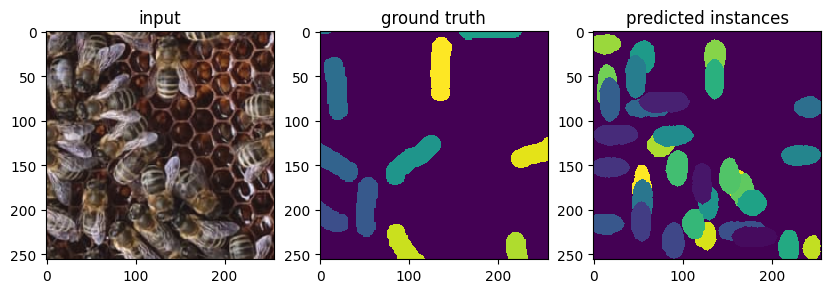

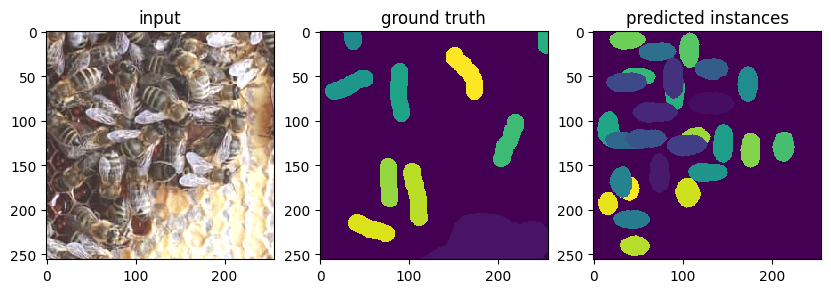

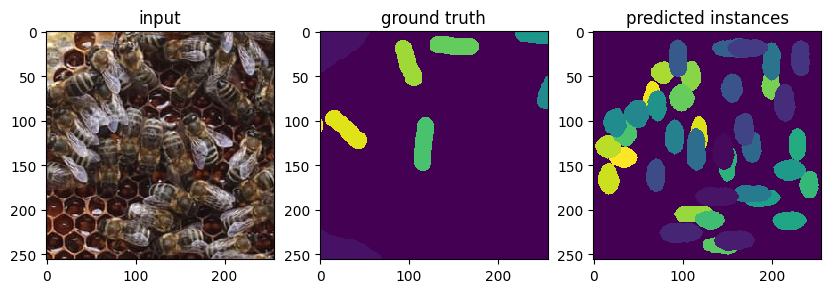

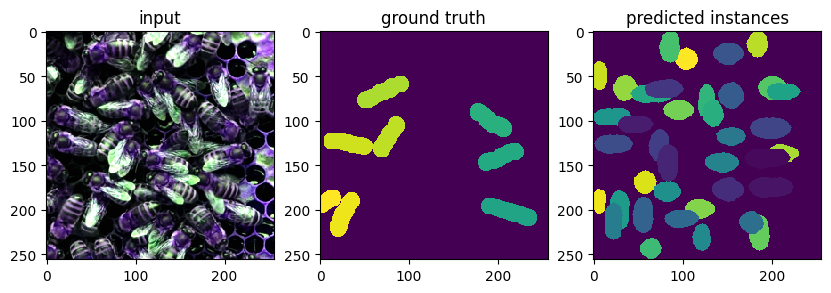

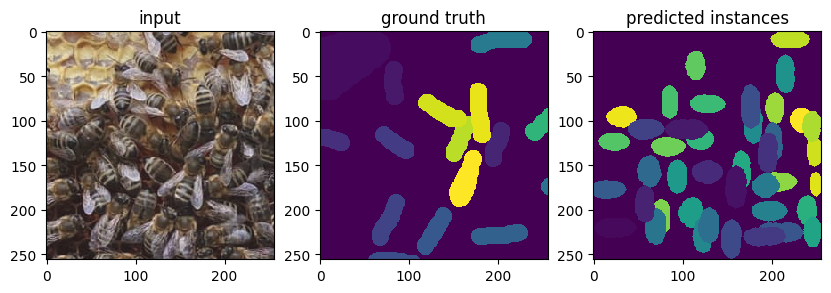

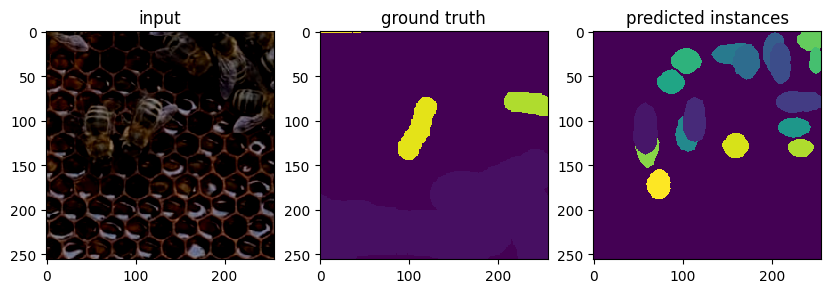

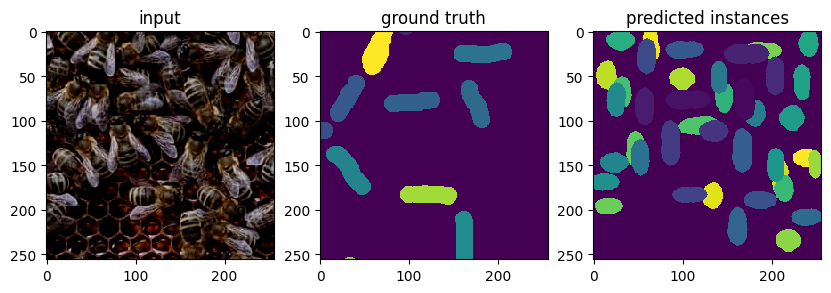

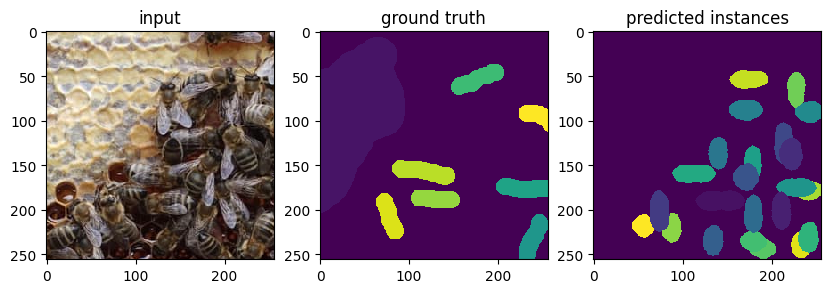

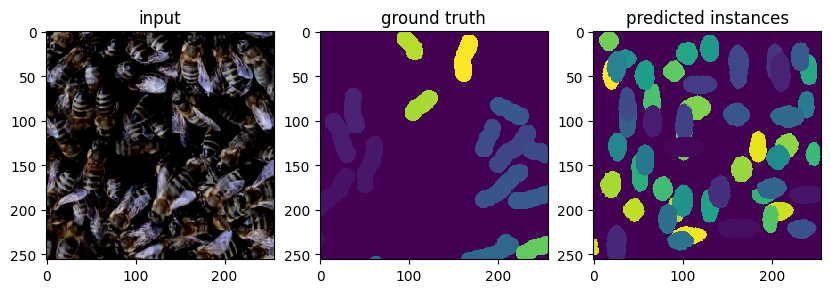

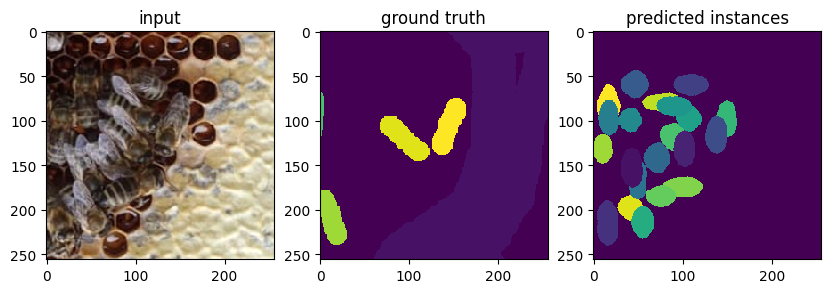

In [15]:
for n in range(10):
    labels, details = model.predict_instances(X_train[n], prob_thresh=0.5, nms_thresh=0.6)
    fig = imshow_multi2d([X_train[n],Y_train[n],labels],['input','ground truth','predicted instances'],1,3)


In [32]:
import napari
viewer = napari.Viewer()
viewer.add_labels(Y_train[9])

<Labels layer 'Labels' at 0x1aef1b1dd20>

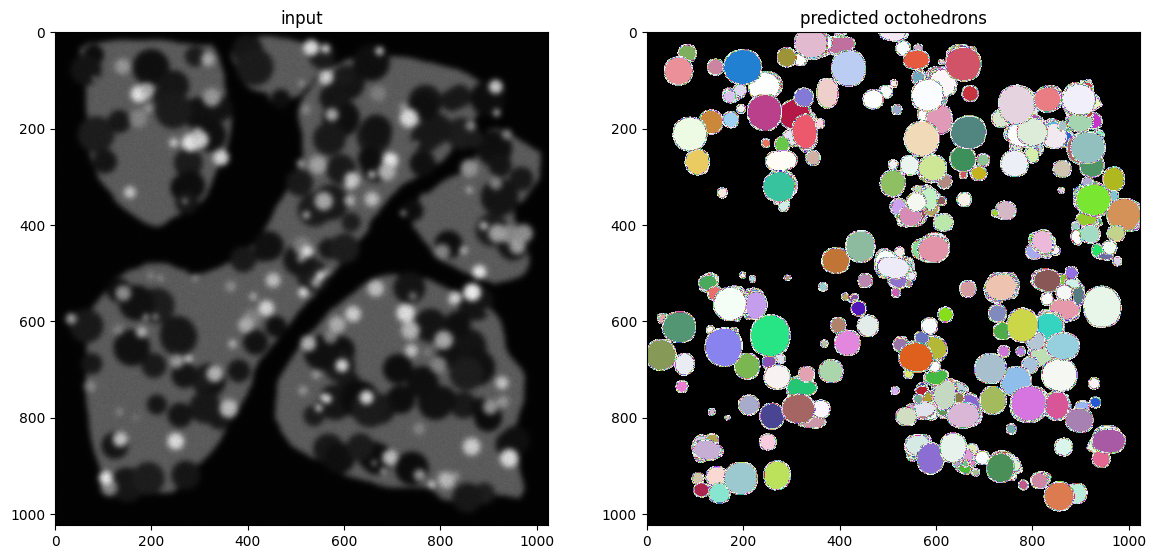

In [19]:
from skimage.io import imread
from tnia.plotting.plt_helper import random_label_cmap
from tnia.deeplearning.dl_helper import ray4_to_ellipsoid2d_labels
from csbdeep.utils import normalize
import numpy as np
test_name='phantom_1.tif'
testim = imread(parent_path  / test_name) 
if (sub_sample != 1):
    testim = testim[::sub_sample,::sub_sample]  
testim = normalize(testim,1,99.8, axis=(0,1))
labels, details = model.predict_instances(testim, prob_thresh=0.5, nms_thresh=0.9)

if n_rays == 4:
    labels2 = np.zeros_like(labels)#ray4_to_ellipsoid2d_labels(details['coord'], testim.shape)
    fig = imshow_multi2d([testim,labels,labels2],['input','predicted octohedrons', 'rendered as ellipses'],1,3, width=14, height=8,colormaps=['gray', random_label_cmap(), random_label_cmap()])
else:
    fig = imshow_multi2d([testim,labels],['input','predicted octohedrons'],1,2, width=14, height=8,colormaps=['gray', random_label_cmap()])

In [20]:
import napari

viewer = napari.Viewer()
viewer.add_image(testim, name='testim')
viewer.add_labels(labels, name='labels2')

<Labels layer 'labels2' at 0x201c1ec86d0>